In [51]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import os


In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
train_data_path = '/content/drive/MyDrive/Colab Notebooks/2_segmentation/2_segmentation/Train/'
test_path = '/content/drive/MyDrive/Colab Notebooks/2_segmentation/2_segmentation/Test/'

# **Data Load Task 2 **

In [56]:
def load(data_directory):
    images_dir = os.path.join(data_directory, 'Ids')
    masks_dir = os.path.join(data_directory, 'GroundTruth')
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))


    # Initialize lists to store resized images and masks
    resized_images = []
    resized_masks = []

    # Loop through images and masks, resize, and append to the
    for img_name, msk_name in zip(image_files, mask_files):
      image = tf.keras.preprocessing.image.load_img(
      os.path.join(images_dir,img_name),target_size = (512,512)
      )
      mask =tf.keras.preprocessing.image.load_img(
      os.path.join(masks_dir,msk_name),color_mode = "grayscale",target_size = (512,512)
      )
      image= tf.keras.preprocessing.image.img_to_array(image)/255.0
      mask= tf.keras.preprocessing.image.img_to_array(mask)/255.0
      resized_images.append(image)
      resized_masks.append(mask)

    return np.array(resized_images),np.array(resized_masks)

resized_images_np,resized_masks = load(train_data_path)
resized_test_images_np,resized_masks_np = load(test_path)
print("Resized Images Shape:", resized_images_np.shape)
print("Resized Masks Shape:", resized_masks.shape)


Resized Images Shape: (400, 512, 512, 3)
Resized Masks Shape: (400, 512, 512, 1)


**Ground Truth and Images**

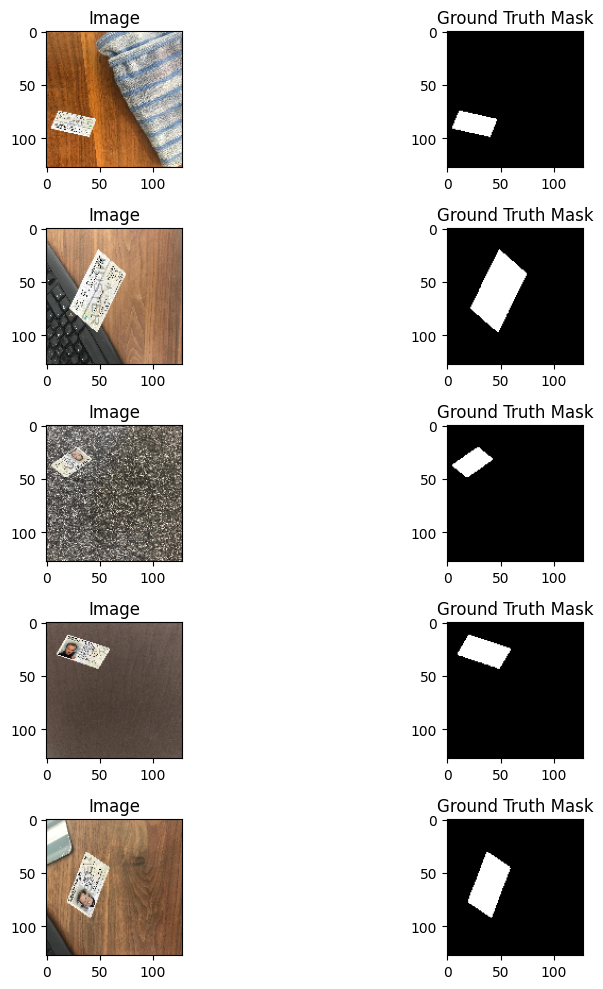

In [ ]:
import matplotlib.pyplot as plt

def visualize_sample(images, masks, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

    for i in range(num_samples):
        index = np.random.randint(len(images))  # Randomly select an index
        image = images[index]
        mask = masks[index]

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')

    plt.tight_layout()
    plt.show()

# Assuming 'train_images' and 'train_masks' are loaded and preprocessed
visualize_sample(resized_images_np, resized_masks)


# MODEL

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def unet(input_shape=(512, 512, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, 3, activation='relu', padding='same')(conv7)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)  # Change 1 to the number of classes for multi-class segmentation

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create an instance of the UNet model
model = unet()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=5,         # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric


In [ ]:
model.fit(resized_images_np ,resized_masks, epochs=10,callbacks=[early_stopping])

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8357 

13/13 [==============================] - 147s 11s/step - loss: 0.5459 - accuracy: 0.8357
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8973 

13/13 [==============================] - 140s 11s/step - loss: 0.3907 - accuracy: 0.8973
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8973 

13/13 [==============================] - 139s 11s/step - loss: 0.3142 - accuracy: 0.8973
Epoch 4/10
13/13 [==============================] - ETA: 0s - loss: 0.2416 - accuracy: 0.8973 

13/13 [==============================] - 149s 11s/step - loss: 0.2416 - accuracy: 0.8973
Epoch 5/10
13/13 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.8973 

13/13 [==============================] - 140s 11s/step - loss: 0.1397 - accuracy: 0.8973
Epoch 6/10
13/13 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9278 

13/13 [==============================] - 140s 11s/step - loss: 0.1142 - accuracy: 0.9278
Epoch 7/10
13/13 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9618 

13/13 [==============================] - 140s 11s/step - loss: 0.1046 - accuracy: 0.9618
Epoch 8/10
13/13 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9369 

13/13 [==============================] - 140s 11s/step - loss: 0.1532 - accuracy: 0.9369
Epoch 9/10
13/13 [==============================] - ETA: 0s - loss: 0.0941 - accuracy: 0.9597 

13/13 [==============================] - 140s 11s/step - loss: 0.0941 - accuracy: 0.9597
Epoch 10/10
13/13 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9726 

13/13 [==============================] - 140s 11s/step - loss: 0.0715 - accuracy: 0.9726


In [ ]:
pred= model.predict(resized_test_images_np)
print(len(pred))

4/4 [==============================] - 21s 5s/step
100


In [54]:
from tensorflow.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/id_card_seg1.h5')

In [57]:

pred= model1.predict(resized_test_images_np)


4/4 [==============================] - 192s 42s/step


#Result Task 2

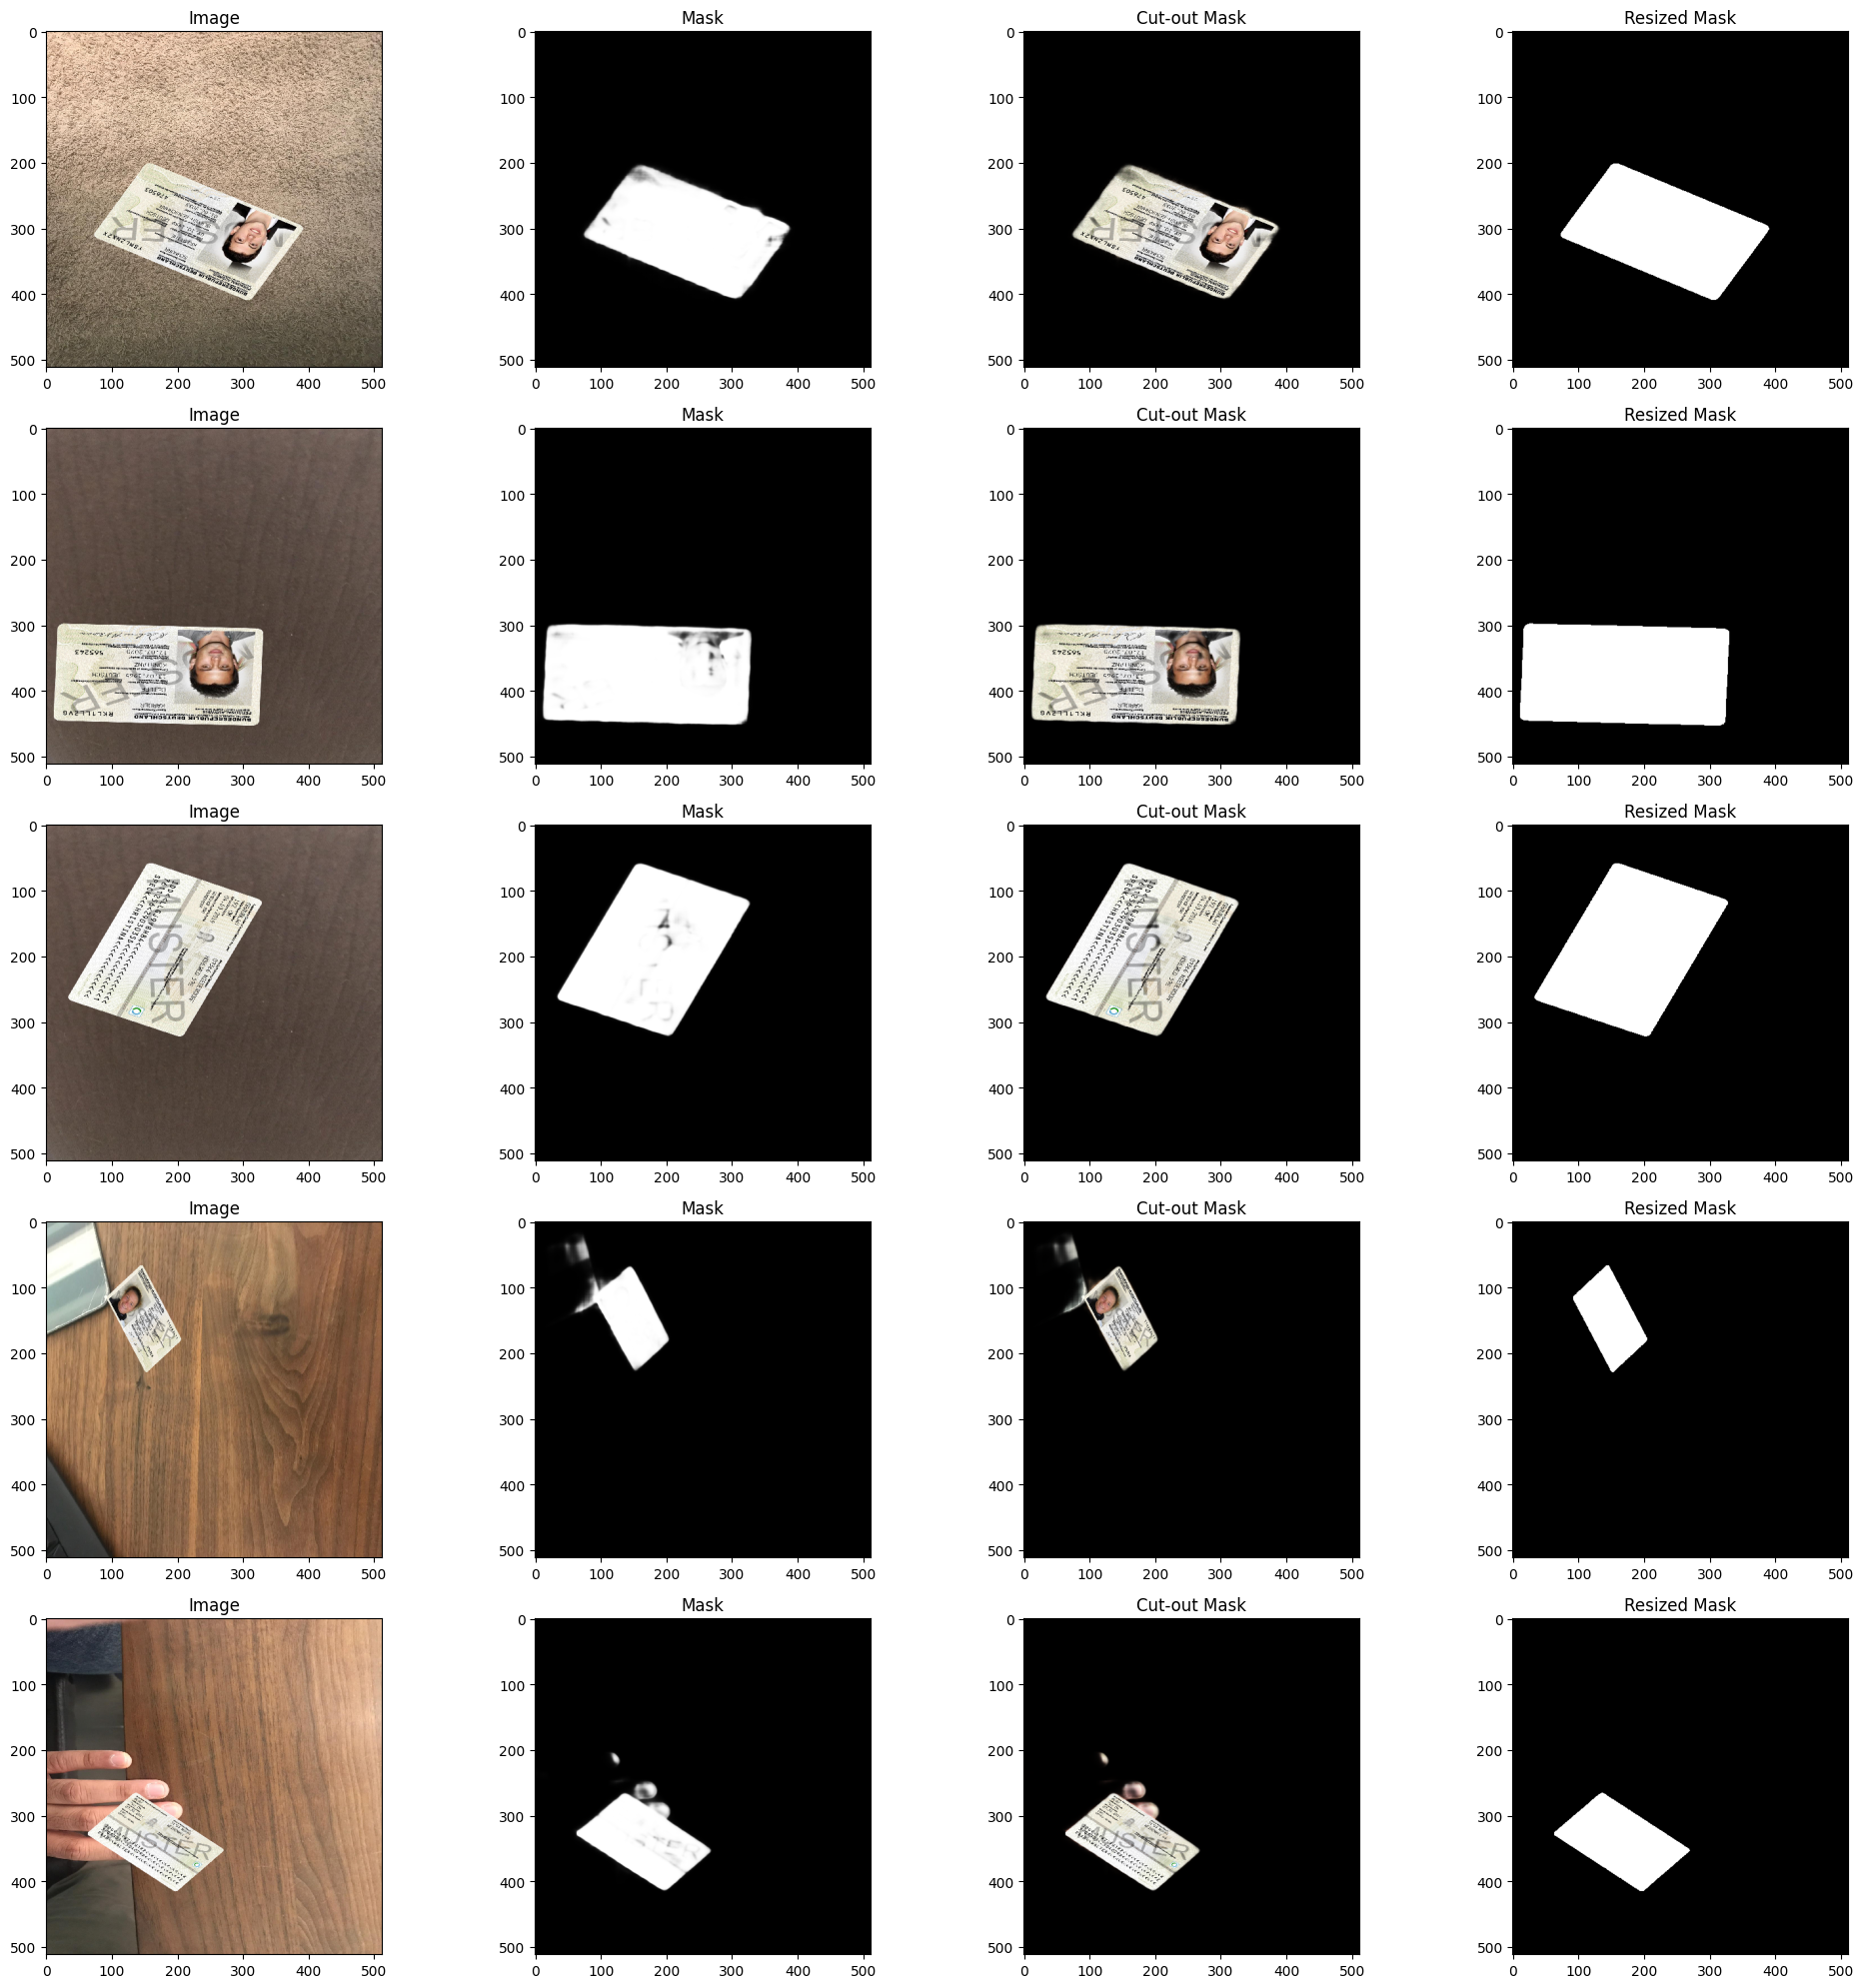

In [58]:
import matplotlib.pyplot as plt


def visualize_sample(images, masks, cut_out, resized_masks, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 20))

    for i in range(num_samples):
        index = np.random.randint(len(images))  # Randomly select an index
        image = images[index]
        mask = masks[index]
        cut_out_mask = cut_out[index]
        resized_mask = resized_masks[index]

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')

        axes[i, 2].imshow(cut_out_mask)
        axes[i, 2].set_title('Cut-out Mask')

        axes[i, 3].imshow(resized_mask, cmap='gray')
        axes[i, 3].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Assuming 'train_images' and 'train_masks' are loaded and preprocessed
cutout = pred * resized_test_images_np
visualize_sample(resized_test_images_np, pred,cutout,resized_masks_np)


# Task 4


In [ ]:
train_data_path_f = '/content/drive/MyDrive/Colab Notebooks/4_cleaning/4_cleaning/Train/'
test_path_f = '/content/drive/MyDrive/Colab Notebooks/4_cleaning/4_cleaning/Test/'

In [65]:
def four_load(data_directory):
    images_dir = os.path.join(data_directory, 'Ids')
    masks_dir = os.path.join(data_directory, 'GroundTruth')
    image_files = sorted(os.listdir(images_dir))
    mask_files = sorted(os.listdir(masks_dir))


    # Initialize lists to store resized images and masks
    resized_images = []
    resized_masks = []

    # Loop through images and masks, resize, and append to the
    for img_name, msk_name in zip(image_files, mask_files):
      image = tf.keras.preprocessing.image.load_img(
      os.path.join(images_dir,img_name),target_size = (512,512)
      )
      mask =tf.keras.preprocessing.image.load_img(
      os.path.join(masks_dir,msk_name),color_mode = "grayscale",target_size = (512,512)
      )
      image= tf.keras.preprocessing.image.img_to_array(image)/255.0
      mask= tf.keras.preprocessing.image.img_to_array(mask)/255.0
      resized_images.append(image)
      resized_masks.append(mask)

    return np.array(resized_images),np.array(resized_masks)

resized_images_np1,resized_masks1 = four_load(train_data_path_f)
resized_test_images_np1,resized_masks_np11 = four_load(test_path_f)
print("Resized Images Shape:", resized_images_np1.shape)
print("Resized Masks Shape:", resized_masks1.shape)

Resized Images Shape: (400, 512, 512, 3)
Resized Masks Shape: (400, 512, 512, 1)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the specified optimizer
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='loss',  # Metric to monitor
                               patience=2,         # Number of epochs with no improvement after which training will be stopped
                         restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored metric

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(resized_images_np1, resized_masks1,  # Training data
#                     validation_data=(x_val, y_val),  # Validation data
                    epochs=5,
                    steps_per_epoch=4,# Maximum number of epochs
                    batch_size=16,       # Batch size
                    callbacks=[early_stopping])  # Early stopping callback


Epoch 1/5


# Task 4 Model Load

In [59]:
from tensorflow.keras.models import load_model
model1 = load_model('/content/drive/MyDrive/Colab Notebooks/id_card_clean.h5')

In [60]:

pred1= model1.predict(resized_test_images_np1,verbose=1)




4/4 [==============================] - 199s 43s/step


4/4 [==============================] - 1s 37ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


# Result Task 4

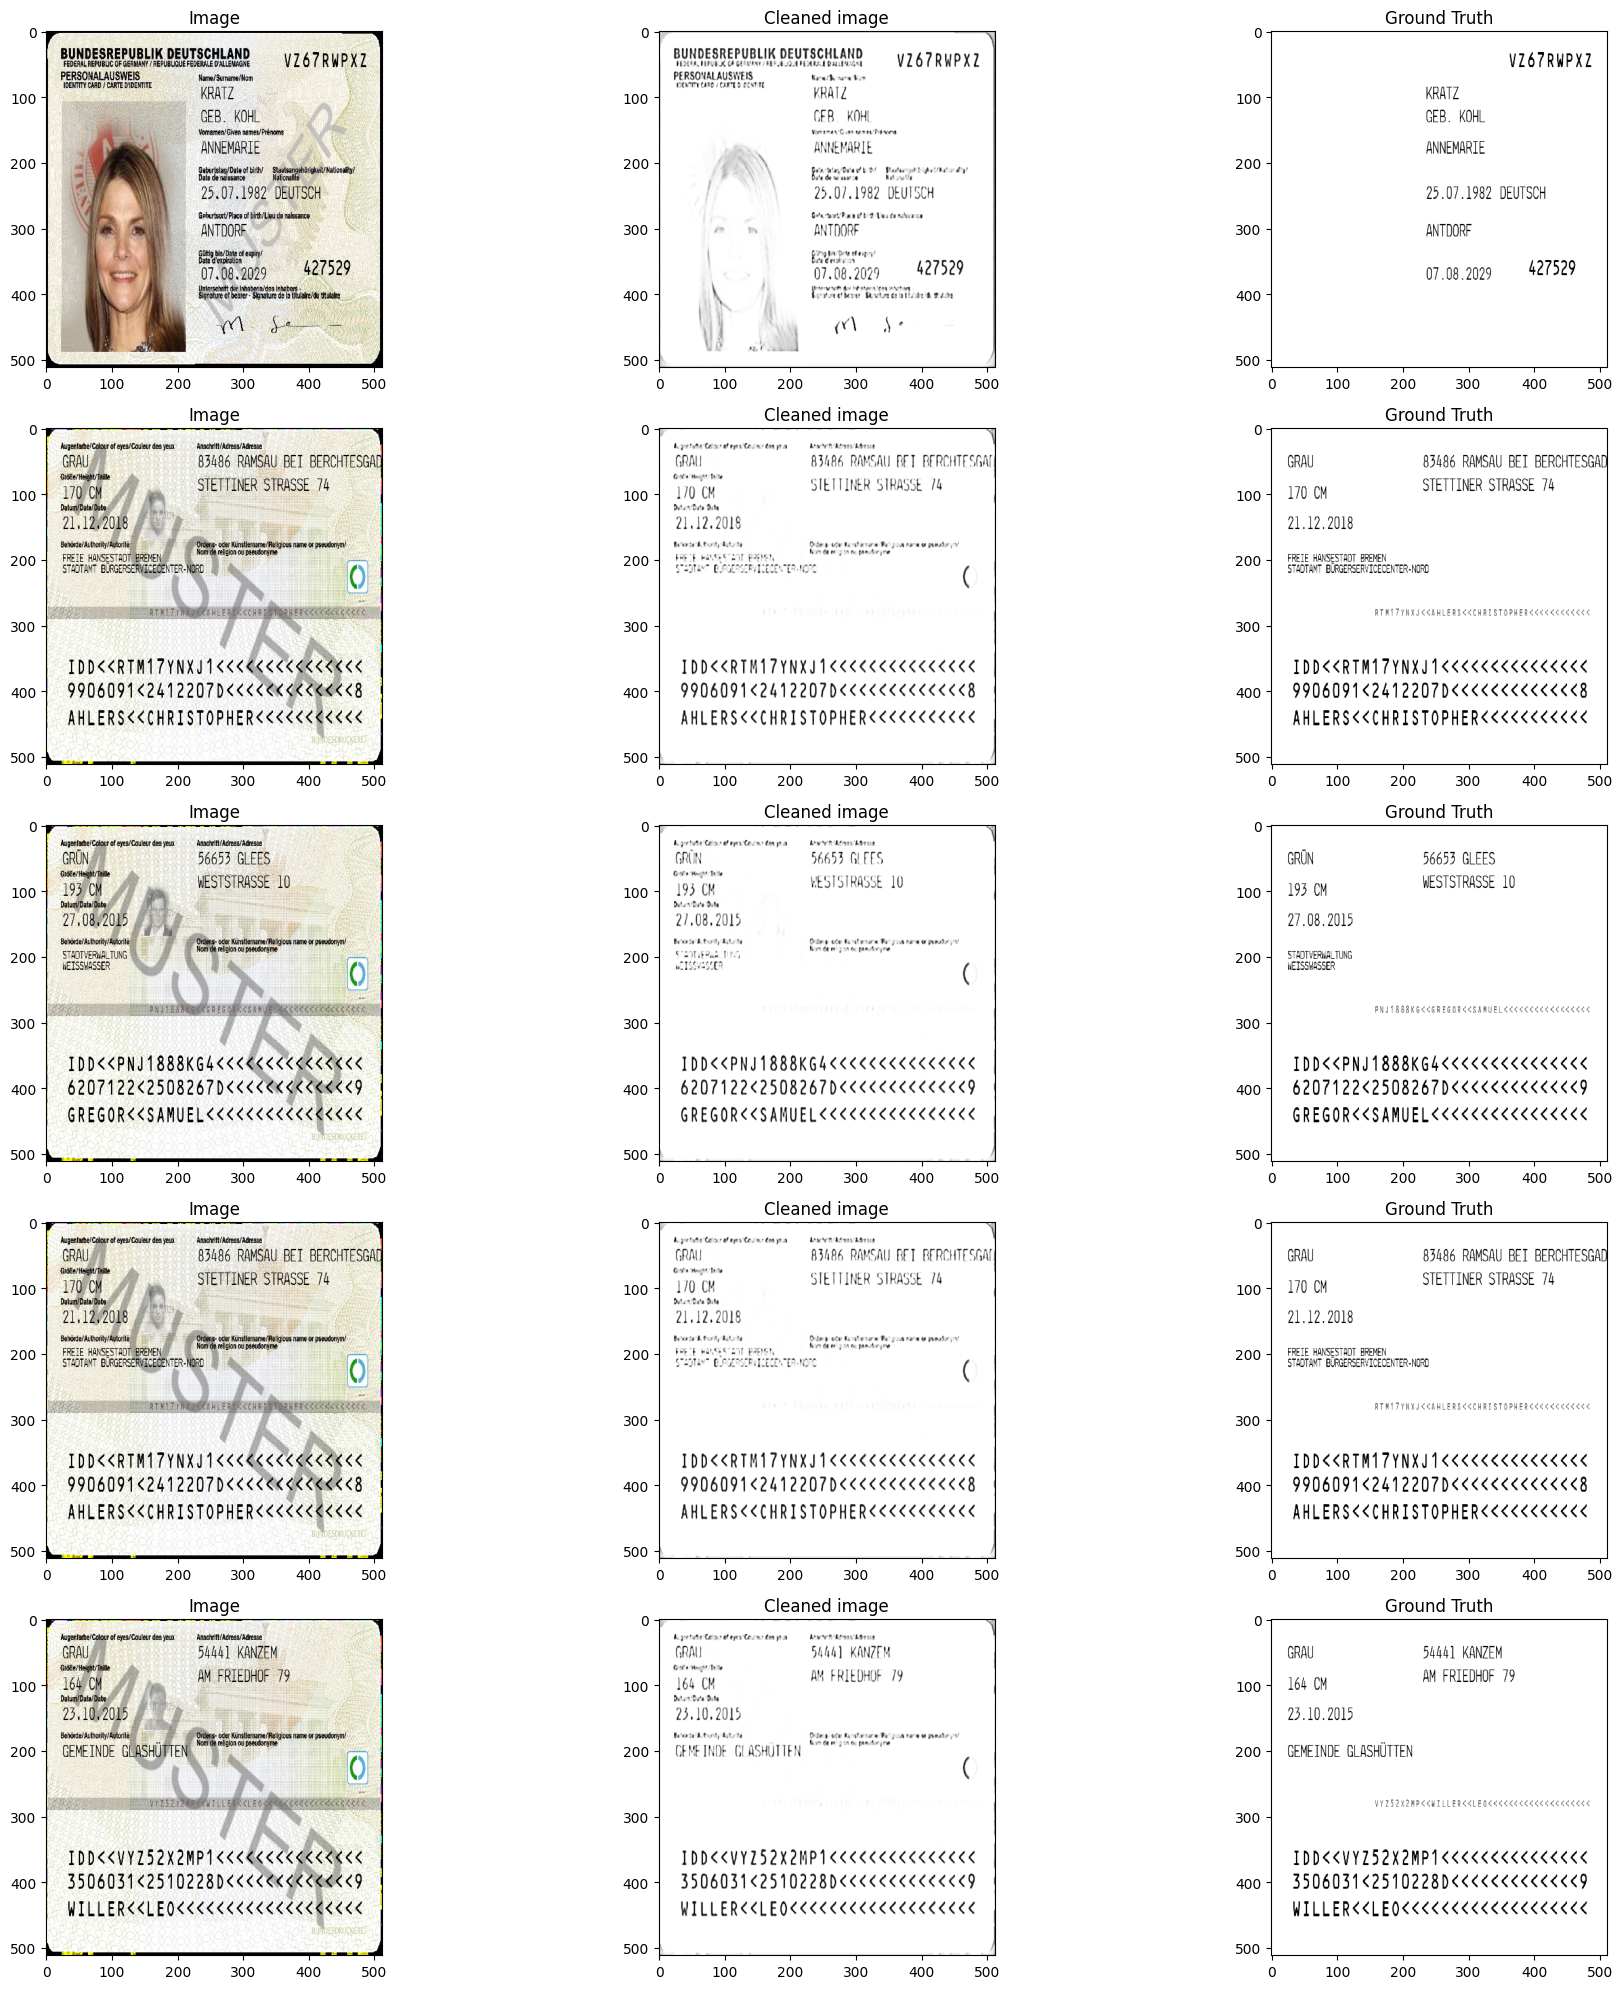

In [66]:
import matplotlib.pyplot as plt


def visualize_sample(images, masks, resized_masks, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 20))

    for i in range(num_samples):
        index = np.random.randint(len(images))  # Randomly select an index
        image = images[index]
        mask = masks[index]

        resized_mask = resized_masks[index]

        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Cleaned image')

        axes[i, 2].imshow(resized_mask, cmap='gray')
        axes[i, 2].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Assuming 'train_images' and 'train_masks' are loaded and preprocessed

visualize_sample(resized_test_images_np1, pred1,resized_masks_np11)